### APMA 4990 - Final Project
- Colton Smith (cfs2140)
- Chaim Eisenbach (ce2388)  
- Rawan Aloula (raa2193)

# Taxi Travel Time Prediction - Colton Smith (cfs2140), Chaim Eisenbach (ce2388), Rawan Aloula (raa2193)

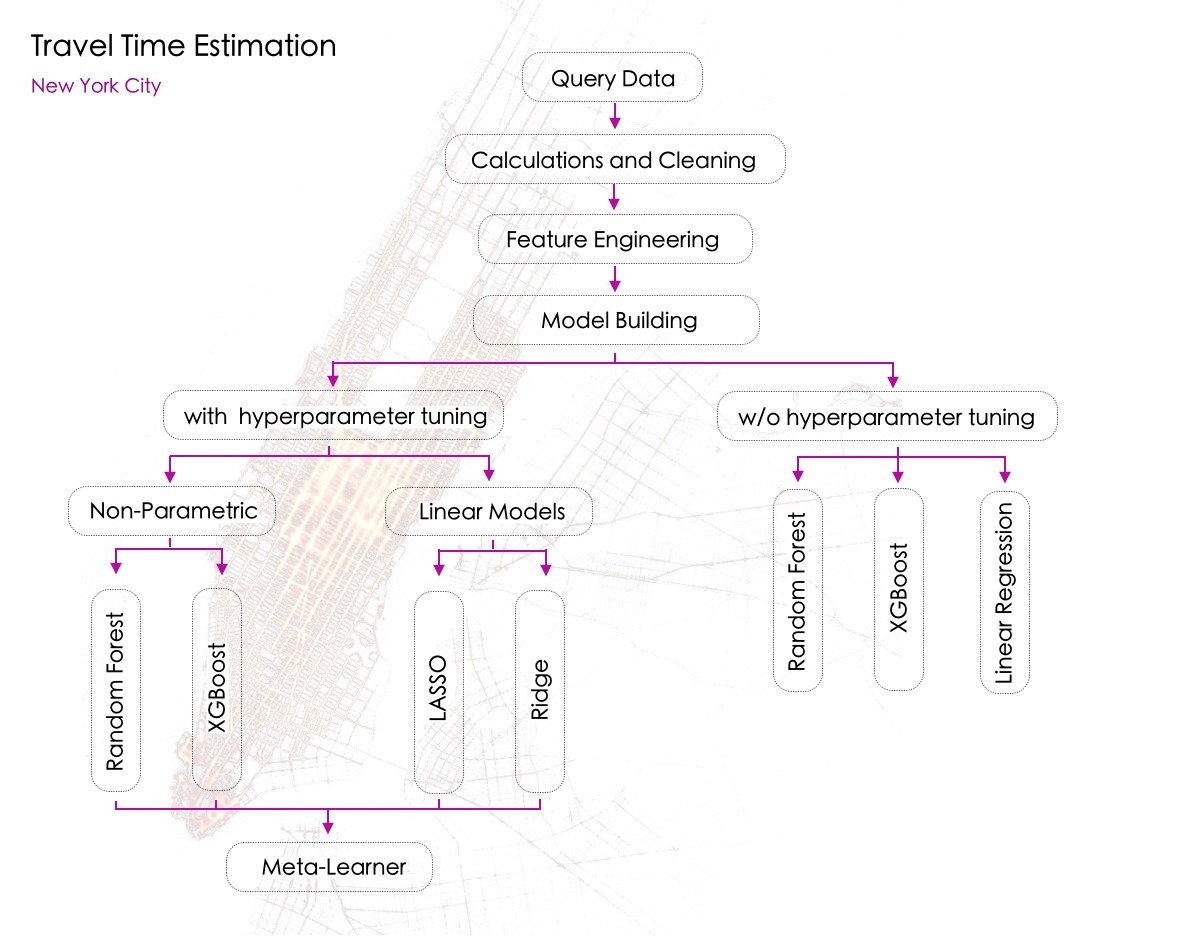

In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from google.cloud import bigquery
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/chaimeisenbach/Downloads/My First Project-726f8769c905.json"

# Introduction

Predicting the travel time between two locations in New York City is an important task for taxi and rideshare companies. They need to know how long trips are to give the rider and accurate estimate, pay their drivers appropriately, and plan out the subsequent trips correctly.

# Data Processing

We use Big Query, a Google cloud service, to access the data. We will use taxi trips from tlc yellow trips and weather data from NOAA. The taxi data needs to be cleaned on retrival since there are NULL entries, locations that aren't in NYC, and travel times that are incorrect. This is done by filtering out entries where values are outside reasonable ranges.

We also calculate the Manhattan, not euclidean distance, between the pickup and dropoff locations. 

Finally we can query all the fields from the taxi and weather dataset that we would like to use.

In [2]:
client = bigquery.Client()

query = (
    """
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    IF(ABS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))) < 1, 
         ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))), 0))
);

SELECT * FROM 
(
SELECT
  pickup_datetime, 
  EXTRACT (DATE FROM pickup_datetime) as date_of_year,
  pickup_latitude,
  pickup_longitude,
  dropoff_latitude,
  dropoff_longitude,
  (HAVERSINE(pickup_latitude,pickup_longitude,pickup_latitude,dropoff_longitude) + HAVERSINE(pickup_latitude,pickup_longitude,dropoff_latitude,pickup_longitude)) AS distance_in_km,
  TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
WHERE TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) > 1 AND TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) < 10000
AND (HAVERSINE(pickup_latitude,pickup_longitude,pickup_latitude,dropoff_longitude) + HAVERSINE(pickup_latitude,pickup_longitude,dropoff_latitude,pickup_longitude)) > 0
AND (HAVERSINE(pickup_latitude,pickup_longitude,pickup_latitude,dropoff_longitude) + HAVERSINE(pickup_latitude,pickup_longitude,dropoff_latitude,pickup_longitude)) < 50
AND pickup_latitude > 40 AND pickup_longitude > -75
AND pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND dropoff_latitude IS NOT NULL
) main
INNER JOIN
(
 SELECT concat(year,'-',mo,'-',da) as date_of_year2,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
 FROM `bigquery-public-data.noaa_gsod.gsod2016` WHERE stn='725053' AND CAST(wdsp AS FLOAT64) < 60.0
) weather_data
ON CAST(main.date_of_year AS STRING) = weather_data.date_of_year2
ORDER BY RAND()
LIMIT 100000;
"""
)
        
df_og = pd.io.gbq.read_gbq(query,dialect='standard')
df_og.head()

,pickup_datetime,date_of_year,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_in_km,travel_time,date_of_year2,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
0,2016-06-14 12:41:42,2016-06-14,40.719231,-74.004639,40.789951,-73.973305,10.490325,3073,2016-06-14,68.0,10.0,4.1,0.00,0,0,0
1,2016-03-22 23:00:14,2016-03-22,40.754318,-73.972679,40.799210,-73.959053,6.131166,801,2016-03-22,43.2,10.0,6.6,0.06,0,0,0
2,2016-06-24 00:10:31,2016-06-24,40.750668,-73.986259,40.761860,-73.994774,1.959108,523,2016-06-24,74.6,8.8,4.8,0.00,0,0,0
3,2016-04-03 13:25:02,2016-04-03,40.758018,-73.971474,40.780003,-73.961479,3.281899,506,2016-04-03,41.0,10.0,10.4,0.25,0,1,1
4,2016-04-12 19:02:28,2016-04-12,40.713951,-74.010490,40.720901,-74.005066,1.228382,253,2016-04-12,54.0,9.1,5.3,0.04,0,1,0


Now we want to make sure that the our data cleaning in the query was successful. As you can see below, the pickup and dropoff locations look good!

In [3]:
df_og.describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_in_km,travel_time,temp,visib,prcp
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,40.750931,-73.973261,40.751911,-73.973435,4.442582,835.813150,50.933436,9.107386,0.090442
std,0.028098,0.038469,0.032203,0.035323,5.182780,650.847775,15.564158,1.354544,0.232196
min,40.493679,-74.370125,40.487179,-74.368835,0.000190,2.000000,6.900000,1.700000,0.000000
25%,40.737350,-73.991867,40.736033,-73.991287,1.570045,397.000000,39.100000,8.700000,0.000000
50%,40.754265,-73.981659,40.754566,-73.979824,2.692586,663.000000,50.900000,9.800000,0.000000
75%,40.768414,-73.967331,40.769901,-73.962936,5.024146,1074.000000,62.400000,10.000000,0.050000
max,41.198368,-73.450806,41.198360,-73.450775,49.317326,9271.000000,79.600000,10.000000,1.820000


Text(0.5, 0, 'Dropoff Longitude')

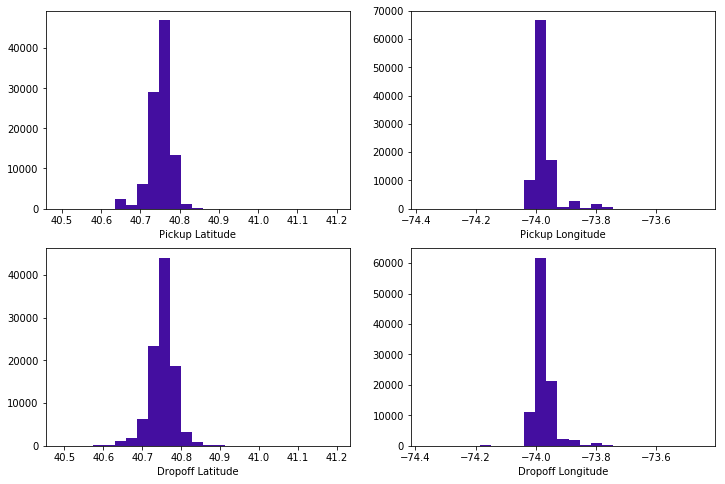

In [4]:
df = df_og.copy()

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

axes = fig.add_subplot(2, 2, 1)
axes.hist(df.pickup_latitude, bins = 25, color = '#440ea0')
axes.set_xlabel('Pickup Latitude')

axes = fig.add_subplot(2, 2, 2)
axes.hist(df.pickup_longitude, bins = 25, color = '#440ea0')
axes.set_xlabel('Pickup Longitude')

axes = fig.add_subplot(2, 2, 3)
axes.hist(df.dropoff_latitude, bins = 25, color = '#440ea0')
axes.set_xlabel('Dropoff Latitude')

axes = fig.add_subplot(2, 2, 4)
axes.hist(df.dropoff_longitude, bins = 25, color = '#440ea0')
axes.set_xlabel('Dropoff Longitude')

Now we will make sure that the travel distance/time and weather data looks clean. We also begin to see how these features influence the dependent variable. Obviously, the longer the distance, the longer the travel time. For the weather data, it looks like when the weather is nicer (no rain, warm, no wind, etc.) that the trips are longer. This is likely because there is more traffic when it is nice out and people are out and about.

Text(0, 0.5, 'Travel Time (s)')

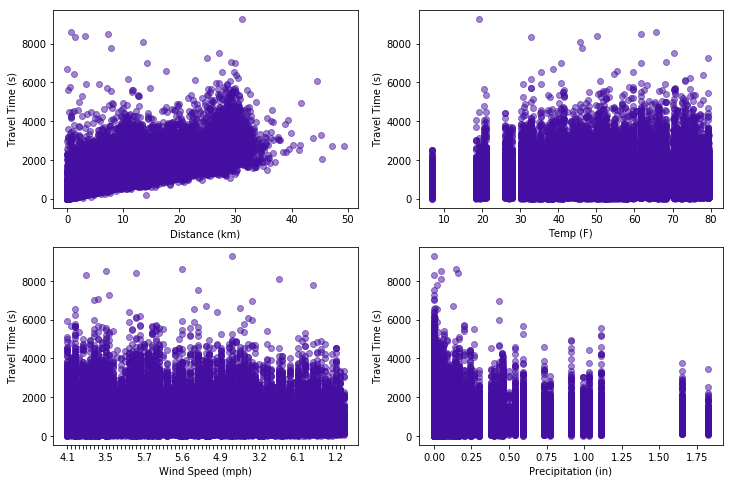

In [5]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

axes = fig.add_subplot(2, 2, 1)
axes.scatter(x = 'distance_in_km', y = 'travel_time', data = df, color = '#440ea0', alpha = 0.5)
axes.set_xlabel('Distance (km)')
axes.set_ylabel('Travel Time (s)')

axes = fig.add_subplot(2, 2, 2)
axes.scatter(x = 'temp', y = 'travel_time', data = df, color = '#440ea0', alpha = 0.5)
axes.set_xlabel('Temp (F)')
axes.set_ylabel('Travel Time (s)')

axes = fig.add_subplot(2, 2, 3)
axes.scatter(x = 'wdsp', y = 'travel_time', data = df, color = '#440ea0', alpha = 0.5)
axes.set_xlabel('Wind Speed (mph)')
axes.set_ylabel('Travel Time (s)')
for n, label in enumerate(axes.xaxis.get_ticklabels()):
    if n % 10 != 0:
        label.set_visible(False)

axes = fig.add_subplot(2, 2, 4)
axes.scatter(x = 'prcp', y = 'travel_time', data = df, color = '#440ea0', alpha = 0.5)
axes.set_xlabel('Precipitation (in)')
axes.set_ylabel('Travel Time (s)')

Finally, lets take a look at our response variable.

Text(0, 0.5, 'KDE')

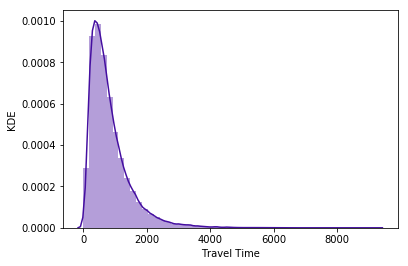

In [6]:
sns.distplot(df.travel_time, color="#440ea0")
plt.xlabel('Travel Time')
plt.ylabel('KDE')

# Feature Engineering

Now we will engineer these features so that they are ready to go into our models. We need to extract dummy variables for the time of day and day of the week from the pickup_datetime field.

We also create a route feature which indicates which cluster of the city the pickup and dropoff locations are in. When this is used in the model, it will provide information on the travel times between certain parts of the city.

,distance_in_km,travel_time,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,hrs_0,hrs_1,hrs_2,hrs_3,hrs_4,hrs_5,hrs_6,hrs_7,hrs_8,hrs_9,hrs_10,hrs_11,hrs_12,hrs_13,hrs_14,hrs_15,hrs_16,hrs_17,hrs_18,hrs_19,hrs_20,hrs_21,hrs_22,hrs_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,route_00,route_01,route_02,route_03,route_04,route_10,route_11,route_12,route_13,route_14,route_20,route_21,route_22,route_23,route_24,route_30,route_31,route_32,route_33,route_34,route_40,route_41,route_42,route_43,route_44
0,10.490325,3073,68.0,10.0,4.1,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,6.131166,801,43.2,10.0,6.6,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.959108,523,74.6,8.8,4.8,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.281899,506,41.0,10.0,10.4,0.25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.228382,253,54.0,9.1,5.3,0.04,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


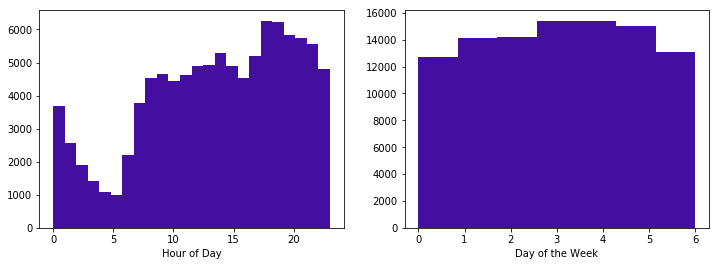

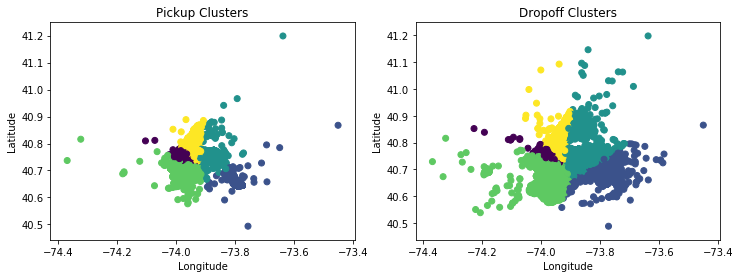

In [7]:
df = df_og.copy()
df['hr_of_day'] = df['pickup_datetime'].dt.hour
df['day_week'] = df['pickup_datetime'].dt.weekday

kmeans_p = KMeans(n_clusters = 5).fit(df[['pickup_latitude', 'pickup_longitude']])
kmeans_d = KMeans(n_clusters = 5).fit(df[['dropoff_latitude', 'dropoff_longitude']])
df['pickup_cluster'] = kmeans_p.predict(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_cluster'] = kmeans_p.predict(df[['dropoff_latitude', 'dropoff_longitude']])
df['clusters'] = df['pickup_cluster'].map(str) +  df['dropoff_cluster'].map(str)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.hist(df.hr_of_day, bins = 24, color="#440ea0")
axes.set_xlabel('Hour of Day')
axes = fig.add_subplot(1, 2, 2)
axes.hist(df.day_week, bins = 7, color="#440ea0")
axes.set_xlabel('Day of the Week')

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.scatter(df.pickup_longitude, 
            df.pickup_latitude,
            cmap = 'viridis',
            c = df.pickup_cluster)
axes.set_title('Pickup Clusters')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')

axes = fig.add_subplot(1, 2, 2)
axes.scatter(df.dropoff_longitude, 
            df.dropoff_latitude,
            cmap = 'viridis',
            c = df.dropoff_cluster)
axes.set_title('Dropoff Clusters')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')

df = pd.concat([df, pd.get_dummies(df['hr_of_day'], prefix = 'hrs')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['day_week'], prefix = 'day')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['clusters'], prefix = 'route')], axis = 1)
df.drop(df.columns[[0,1,2,3,4,5,8,16,17,18,19,20]], axis = 1, inplace = True)

df.head()

The histograms above show when taxis are most busy. Let's plot a correlation matrix of our features and response variable to see if there are any significant correlations.

In [8]:
y = df['travel_time']
df.drop(df.columns[[1]], axis = 1, inplace = True)
features = list(df.columns.values)
X = df.copy()
X = X.apply(pd.to_numeric)

X_og = X.copy()
y_og = y.copy()

print('Features: ', features)

Features:  ['distance_in_km', 'temp', 'visib', 'wdsp', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hrs_0', 'hrs_1', 'hrs_2', 'hrs_3', 'hrs_4', 'hrs_5', 'hrs_6', 'hrs_7', 'hrs_8', 'hrs_9', 'hrs_10', 'hrs_11', 'hrs_12', 'hrs_13', 'hrs_14', 'hrs_15', 'hrs_16', 'hrs_17', 'hrs_18', 'hrs_19', 'hrs_20', 'hrs_21', 'hrs_22', 'hrs_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'route_00', 'route_01', 'route_02', 'route_03', 'route_04', 'route_10', 'route_11', 'route_12', 'route_13', 'route_14', 'route_20', 'route_21', 'route_22', 'route_23', 'route_24', 'route_30', 'route_31', 'route_32', 'route_33', 'route_34', 'route_40', 'route_41', 'route_42', 'route_43', 'route_44']


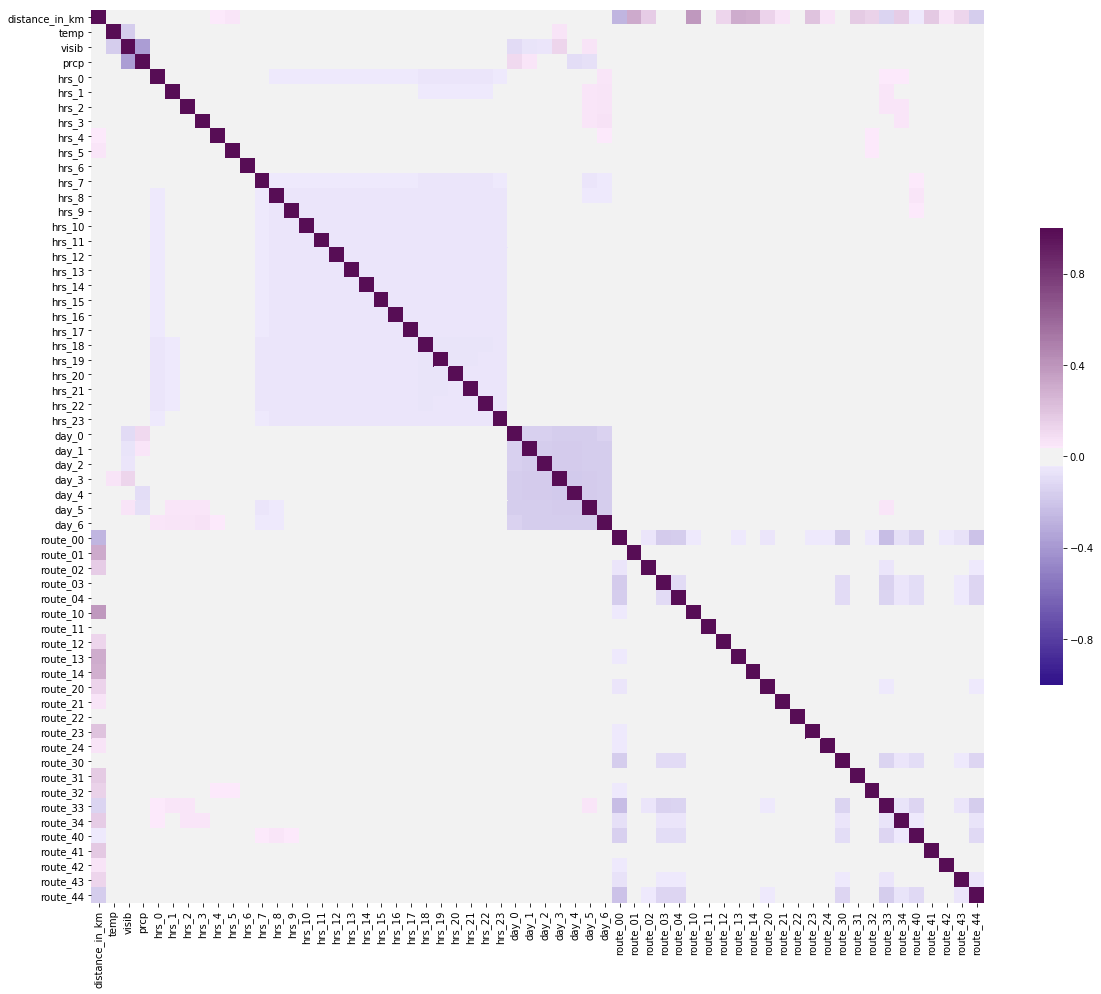

In [9]:
corr = df.corr()
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(270 , 310 , s=90 , l=20, n=200),
    cbar_kws={"shrink": .42},
    square=True
)

There are some decent correlations between routes and travel time. There is also a strong correlation between distance and travel time as expected. Now we seperate the features from the response variable.

# Model Building

We are focusing on one class of models - **Supervised learning**

Regression: 

- Linear Regression, Random Forest, and XGBoost (implementation of the Gradient Boosted Trees algorithm). 

Here we are using regression to refer to a problem specifically with a quantitative response.

The goal of regression is to fit a mathematical model to a set of observed points.

Regression was initially used by Frances Galton to refer to "Regression towards mediocrity in hereditary stature” which was later shortened to “regression to the mean”. It’s unstable in the short run but after a while it will be closer to the average. 

Any singular measurement can stand the risk of failing our predictions. Like sometimes guessing the anwers on a test can yield positive or negative results. But done multiple times it will yield ‘mediocre’ results i.e. you will only get half right if done on a true/false exam. Estimation or prediction could be better words. They don’t make any assumptions about the behavior of the data initially, while Regression seems to imply a very specific thing about the behavior of the data which may or may not be true.


Supervised learning requires 3 things:
- The data
- Candidate functions that can approximate reality
- An algorithm $A$ that uses the data to pick the best candidate function.

There are also three primary sources of error:
- Estimation error - that can be minimized with a bigger population $n$
- Misspecifcation error - that can be minimized with a better algorithm $A$
- Error due to ignorance - that can be minimized with better data


### 1 Linear Regression

Once we choose the model to use then we need to be able to actually model the data itself. In order to do so we use Ordinary Least Squares (OLS) to fit the data.

Our data consists of $n$ paired observations of the predictor variable $X$ and the
response variable $Y$. So we have the pairs $(x_1,y_1)...(x_n,y_n)$ and we want to fit a model $$\beta_0 + \beta_1 X + \epsilon = Y$$ Where $\epsilon$ represents the estimation error and the residuals.

[From the course notes](https://github.com/Columbia-Intro-Data-Science/APMAE4990-):
Thus our goal is to find $f:X \to Y$ such that
\begin{equation}
f^*(x) = \textrm{argmin}_{f \in L^p} |y - f(x)|^p = \textrm{argmin}_{f \in L^p} \sum_{i=1}^N |y_i - f(x_i)|^p.
\end{equation}

When $p=2$ then we have the analytical solution:
$$
\frac {\partial}{\partial \beta} (\vec y^T \vec y - 2 \vec \beta^T X^T \vec y + \vec \beta^T X^T X \vec \beta) = \frac {\partial}{\partial \beta} (\vec y^T \vec y) -  2\frac {\partial}{\partial \beta}(\vec \beta^T X^T \vec y) + \frac {\partial}{\partial \beta} (\vec \beta^T X^T X \vec) = \vec 0 - 2X^T \vec y + 2 X^T X \vec \beta = 0 
\\
X^T \vec y = X^TX \vec \beta
$$

So we get $$ \beta = (X^TX)^{-1}X^T y.$$

Since this model is linear it is rather unflexible.

Note: In a situation where we have $X$ with dimension $n$ x $(p+1)$ but $p+1 > n$ and we still want to do OLS. OLS will break down because if $X$ is not full rank then $X^⊤X$ is not invertible and there is no unique solution.


Below we implement a simple linear regression model, with 5-fold cross-validation.

In [10]:
lm_R2 = []
lm_RMSE = []

folds = 5
for k in range(folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lm_reg = LinearRegression()
    lm_reg.fit(X_train,y_train)
    lm_R2.append(lm_reg.score(X_test,y_test))
    y_pred = lm_reg.predict(X_test)
    lm_RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
   
print('R^2 : ', round(np.mean(lm_R2),2))
print('RMSE : ', round(np.mean(lm_RMSE),0))

R^2 :  0.64
RMSE :  387.0


## Random Forest

Bagging, random forests, and boosting use trees as building blocks to construct more powerful prediction models.
A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. 

The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. 

There is a trade-off between underfitting (low variance/high bias) and overfitting (high variance/low bias).
Regression trees have low bias and high variance (they overfit).
But can we average many trees.

**Bootstrap:**
- Sample $n$ rows from our dataset $\mathcal{D}$ ***with replacement*** (the Bootstrap sample)
- Estimate coefficient
- look at standard deviation of distribution of estimates

If you take the average of the trees you get the aggregate tree.

**Bootstrap + Aggregation** *(Breiman 1996)* = The "mean-algorithm" which improves for instability (high variance algorithms). Imagine a tree $g_t$ it has low bias and high variance. You then take $T$ trees averaged $g_{bagged} = \frac{g_1 + ... g_t}{T}$ which has low bias.

**Bagging:**
- Sample $n$ rows from our dataset $\mathcal{D}$  
- Calculate the mean of each sub-sample.
- Calculate the average of all of our collected means and use that as our estimated mean for the data.

Bagging works really well because:

- You don't need to specify a model or do model selection since trees figure out the model for you.
- No need to specify hyperparameters 
- You get validation for free so there is no need for k-fold cross validation.

How about at each split, pick a random subset of features and then minimize SSE (sum of squared error). The bias will go up, but not too much. Each tree is random, together, it's called a **"Random Forest"** (Breiman 2001). Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. each time a split in a tree is considered, a random sample of predictors is chosen as split candidates from the full set of predictors. The split is allowed to use only one of those predictors. So then at each split you'll have a new sample of predictors. We end up with a collection of bagged trees that will be using the predictor that we picked out. 

In other words, in building a random forest, at each split in the tree, the algorithm is not even allowed to consider a majority of the available predictors.

So you do this a whole bunch of times and you'll build up some distribution  where $\hat{w}$ is our estimate and we look at the width of the distribution so the standard deviation of this distribution is the standard error on the coefficient estimate. If you have a small sample the distribution will be wider than if you had a large sample of data.

If you have enough data you'll get a really tight distribution and still a small standard error. 

Statistical Inference for Trees and Random Forests is a very active area of research right now. The basic problem is the parameters aren't fixed - They grow and mutate with the data itself. Which makes the parameters hard to pin down and inference on them difficult. The same for prediction intervals.

Below we train a random forest with the default parameters. 

In [11]:
rf_R2 = []
rf_RMSE = []
folds = 5
for k in range(folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train,y_train)
    rf_R2.append(rf_reg.score(X_test,y_test))
    y_pred = rf_reg.predict(X_test)
    rf_RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    lm_RMSLE.append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
print('R^2 : ', round(np.mean(rf_R2),2))
print('RMSE : ', round(np.mean(rf_RMSE),0))

/Users/chaimeisenbach/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


NameError: name 'lm_RMSLE' is not defined

## XGBoost


From our explanation above we can see how we can build models on each other iteratively so the errors of the previous model are corrected by the next predictor, until the training data is accurately predicted or reproduced by the model. One such ensemble is **Gradient Boosting**. But in doing so it can lead to such complicated estimates of $f$ that it is difficult to understand how any individual predictor is associated with the response. Boosting can be interpreted as an optimization algorithm on a suitable cost function *(Breiman 1996)*.

Random Forests are still using Regression trees, which have low bias and high variance (they overfit). But since we build a number of decision trees on bootstrapped training samples, each time a split in a tree is considered, a random sample of predictors is chosen as split candidates from the full set of predictors. The split is allowed to use only one of those predictors.

Gradient Boosting is slightly different - the idea is to add one predictor at a time, so that the next predictor is trained to improve the already trained ensemble as opposed to being trained independantly. 

The Gradient Boosting algorithm computes residuals and optimizes for those alone.[From the course notes](https://github.com/Columbia-Intro-Data-Science/APMAE4990-):

- Initialize the model with a constant value 
$$F_0(x) = \text{arg min}_\gamma \sum_{i=1}^n L(y_i,\gamma)$$
- For all m: Compute so-called pseudo-residuals:
$$
r_{im} = - [ \frac{\partial L(y_i,F(x_i))}{\partial F(x_i)}]_{F(x) = F_{m-1}(x)} \qquad \text{for}~~ i= 1,....,n.
$$

- Compute multiplier $\gamma_m$ by solving the following one-dimansional problem:
$$
\gamma_m = \text{arg min}_\gamma \sum_{i=1}^n L(y_i,F_{m-1}(x_i) + \gamma h_m(x_i))
$$

- Update the model:
$$
F_m (x) = F_{m-1}(x) \gamma_m h_m(x)
$$

- Output $F_m (x)$

XGBoost stands for eXtreme Gradient Boosting. XGBoost is an ensemble learning method. 
It was developed by [Tianqi Chen](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf) at the University of Washington . XGBoost is a scalable and accurate implementation of gradient boosting machines. It is a supervised learning method that is based on function approximation by optimizing specific loss functions as well as applying several regularization techniques. "It is a highly flexible and versatile tool that can work through most regression, classification and ranking problems as well as user-built objective functions." -  [Ilan Reinstein, KDnuggets.](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html)


Below we train a XGBoost model with the default parameters.

In [ ]:
xgb_R2 = []
xgb_RMSE = []

folds = 5
for k in range(folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train,y_train)
    xgb_R2.append(xgb_reg.score(X_test,y_test))
    y_pred = xgb_reg.predict(X_test)
    xgb_RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
print('R^2 : ', round(np.mean(xgb_R2),2))
print('RMSE : ', round(np.mean(xgb_RMSE),0))

Without any tuning XGBoost is the top performer, followed by random forest, and finally linear regression.

Now let's take a closer look at each model and do some hyper parameter tuning and feature importance analysis.

## Linear Models
### Lasso, Ridge, and Regularization

We can extend linear models in order to accommodate non-linear, but still additive, relationships (ISLR). One way to due this is regularization. To control variance we ***regularize*** the coefficients  to control how large the coefficients grow. Regularization is a way to penalize model complexity to allow it to generalize well into the future. 

There are two specific regularization techniques we will focus on. When $p =1$ we get the *Lasso* norm and when $p=2$ we get the *Ridge* norm.

**Ridge Regression** - $L^2$ (Hoerl and Kennard in 1970)

Ridge regression will add a penalty so we are minimizing:

\begin{equation}
  \frac{1}{N} \sum_{i=1}^{N} |y_i - \beta x_i|^2 + \lambda \sum_{i=1}^N |\beta_i|^2
\end{equation}

Which we showed in the homework: 
$$
(y-X \beta)^\top (y - X \beta) + \lambda \beta^\top \beta  \Rightarrow y^\top y - X^\top \beta^\top y - y^\top X \beta + \beta^\top X^\top X \beta + \lambda \beta^\top \beta \Rightarrow y^\top y - 2w^\top X^\top y + \beta^\top (X^\top X + \lambda I) \beta \\
-2 X^\top y +2(X^\top X + \lambda I) \beta \Rightarrow \beta = (\mathbf X^T\mathbf X +\lambda I)^{-1} \mathbf X^Ty
$$

As the $\lambda$ value increases the coefficient decreases. Thus, the weights are brought down for the model to generalize well. We can’t give much importance to each feature since we don’t have enough data to be confident in the weight of our predictors. Ridge regression prevents overfitting by limiting the weights so our model doesn’t get out of control. So, many of the values of the entries of the ridge estimator are close to 0. 

In situations where the relationship between the response and the predictors is close to linear, the least squares estimates will have low bias but may have high variance. whereas ridge regression can still perform well by trading off a small increase in bias for a large decrease in variance. Hence, ridge regression works best in situations where the least squares estimates have high variance.

The ridge penalty is beautiful because we're able to take the derivative and get an analytical solution.
In “lasso regression” the values of the lasso estimator are not necessarily shrunk towards 0 they are harshly punished directly to 0. So it might weed out the "useless predictors". This way we can look at the more important predictors which have a stronger relationship to $y$.

**Lasso Regression** - $L^1$

Lasso regression will add a penalty so we are minimizing:

\begin{equation}
  \frac{1}{N} \sum_{i=1}^{N} |y_i - \beta x_i|^2 + \lambda \sum_{i=1}^N |\beta_i|
\end{equation}

As with ridge regression, the lasso shrinks the coefficient estimates towards zero. However, in the case of the lasso, the $L^1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large. Hence, the lasso performs variable selection. As a result, models generated from the lasso are generally much easier to interpret than those produced by ridge regression. 


In [ ]:
alpha_R2s = []
alphas = np.linspace(0,1,5)

folds = 3
for a in alphas:
    lasso_R2 = []
    for k in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        ### Regularization ###
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        lasso_reg = Lasso(alpha = a)
        lasso_reg.fit(X_train,y_train)
        lasso_R2.append(lasso_reg.score(X_test,y_test))
        y_pred = lasso_reg.predict(X_test)
    
    alpha_R2s.append(round(np.mean(lasso_R2),2))
    
print('Best Lasso R2 : ',max(alpha_R2s), ' with alpha : ',alphas[np.argmax(alpha_R2s)])

In [ ]:
alpha_R2s = []
alphas = np.linspace(0,1,15)

folds = 3
for a in alphas:
    ridge_R2 = []
    for k in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        ### Regularization ###
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        ridge_reg = Ridge(alpha = a)
        ridge_reg.fit(X_train,y_train)
        ridge_R2.append(ridge_reg.score(X_test,y_test))
        y_pred = ridge_reg.predict(X_test)
    
    alpha_R2s.append(round(np.mean(ridge_R2),2))
    
print('Best Ridge R2 : ',max(alpha_R2s), ' with alpha : ', alphas[np.argmax(alpha_R2s)])

Unfortunately we couldn't simply use LassoCV, RidgeCV, or GridSearchCV because we had to make sure that the features were standardized by the training data each time.

Lasso sets more coefficients to zero since it is an $L^1$ penalty while Ridge is an $L^2$ penalty. $L^1$ level set is more likely to penalize entire coefficients than dsitribute the penality across coefficients. This is because the level set is a square vs a circle. The countours are likely to hit a point of the square which corresponds to a single coefficient while everywhere on the circle is equally likely. Below we create an example to highlight this.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Regularization ###
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lasso_reg = Lasso(alpha = 10)
lasso_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train,y_train)

plt.bar(x = range(0,len(ridge_reg.coef_)), height = ridge_reg.coef_, color="#f442e5", label = 'Ridge')
plt.bar(x = range(0,len(lasso_reg.coef_)), height = lasso_reg.coef_, color="#440ea0", alpha = 0.5, label = 'Lasso')
plt.legend()

When the penalities are large, Lasso makes quite a few features zero while Ridge keeps them around but very small.

## Non-Parametric Models
### Feature Importance from Random Forest Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train,y_train)
y_pred = rf_reg.predict(X_test)
importances = rf_reg.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(5, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color="#440ea0", align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

This plot shows that most important features are the distance, weather, day of the week, time of the day, and cluster routes.

### Hyperparameter Tuning
#### XGBoost

There are few XGBoost parameters that are valuable to tune which we will do with GridSearchCV.
- Learning Rate: Controls the iteration size to prevent overfitting
- Max Depth: The maximum depth of the tree created. The deeper the tree, the more likely to overfit.
- Subsample: The percentage of training points to sample each iteration.
- Column Sample by Tree: The percentage of features to use in each tree.
- Number of Estimators: Using more estimators will always improve performance but it comes with a computational cost.
- Gamma: Acts a regularization parameter to avoid excessive partitions of leaf nodes.

In [ ]:
xgb_reg = xgb.XGBRegressor()

parameters = {'objective':['reg:linear'],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 6],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.3, 0.8],
              'n_estimators': [100],
              'gamma': [0,1]}

xgb_grid = GridSearchCV(xgb_reg, parameters, cv = 2, n_jobs = -1, verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

#### Random Forest Regression

There are few Random Forest parameters that are valuable to tune which we will do with GridSearchCV.

- Max Features: The number of features considered when making splits
- Min Samples Leaf: The minimum number of samples required at a leaf node of a tree.
- Min Samples Split: The minumum number of samples to split a tree node.
- Number of Estimators: Using more estimators will always improve performance but it comes with a computational cost.

In [ ]:
rf_reg = RandomForestRegressor()

parameters = {
    'max_features': ['sqrt', 0.2],
    'min_samples_leaf': [3, 50],
    'min_samples_split': [2, 0.2],
    'n_estimators': [100]
}

rf_grid = GridSearchCV(rf_reg, parameters, cv = 2, n_jobs = -1)

rf_grid.fit(X, y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

The tuned XGBoost is the standout model with a 0.72 R2. Let's see if incorporating all 3 model's predictions can make it any better. 

## Meta-Learner

It may be a advantageous to introduce another model called a meta-learner that takes the predictions from our three models and outputs a final prediction. These models have their strengths and weaknesses so this can improve robustness and avoid overfitting.

A naive approach is to simply average out outputs of the individual models. This is implemented below and improves performance!

In [ ]:
ensemble_RMSE = []

folds = 3
for k in range(folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    lm_reg = LinearRegression()
    lm_reg.fit(X_train,y_train)
    y_pred_lm = lm_reg.predict(X_test)

    xgb_reg = xgb_grid.best_estimator_
    xgb_reg.fit(X_train,y_train)
    y_pred_xgb = xgb_reg.predict(X_test)

    rf_reg = rf_grid.best_estimator_
    rf_reg.fit(X_train,y_train)
    y_pred_rf = rf_reg.predict(X_test)

    pred_test = pd.DataFrame(data = {'lm' : y_pred_lm, 'xgb' : y_pred_xgb, 'rf' : y_pred_rf})
    ensemble = pred_test.mean(axis = 1)

    ensemble_RMSE.append(np.sqrt(mean_squared_error(y_test, ensemble)))

print('RMSE : ', np.mean(ensemble_RMSE))

In [ ]:
plt.scatter(x = ensemble, y = y_test, color="#440ea0", alpha = 0.5)
plt.xlabel('Predictions')
plt.ylabel('Actual')

This has a better RMSE than the individual models!

Rather than just taking the mean, the smart thing to do would be to run another model like a random forest but we will leave that for further exploration.

# Validation Set

In [ ]:
def RADIANS(x):
    return np.arccos(-1) * x / 180

def RADIANS_TO_KM(x):
    return 111.045 * 180 * x / np.arccos(-1)

def HAVERSINE(lat1, long1, lat2, long2):
    val = 0
    pos = np.cos(RADIANS(lat1)) * np.cos(RADIANS(lat2)) * np.cos(RADIANS(long1) - RADIANS(long2)) + np.sin(RADIANS(lat1)) * np.sin(RADIANS(lat2))
    if (abs(pos) < 1):
        val = RADIANS_TO_KM(np.arccos(pos))
    return val

valid_set = pd.read_csv('APM4990_final_test_data_filtered.csv')
valid_set.pickup_datetime = pd.to_datetime(valid_set.pickup_datetime)
valid_set['date_of_year'] = valid_set.pickup_datetime.dt.date
valid_set['distance_in_km'] = valid_set.apply(lambda row: HAVERSINE(row.pickup_latitude,row.pickup_longitude,row.pickup_latitude,row.dropoff_longitude) + 
                                       HAVERSINE(row.pickup_latitude,row.pickup_longitude,row.dropoff_latitude,row.pickup_longitude),
                                       axis = 1)
valid_set_og = valid_set.copy()
valid_set.head()

In [ ]:
valid_set.describe()

There are entries with the same pickup and dropoff point but are just going to leave them.

In [ ]:
subset = valid_set[valid_set.distance_in_km == 0]
subset.head()

Now we need to join it with all the features and make sure it is in the same format as the training data.

In [ ]:
query = (""" SELECT concat(year,'-',mo,'-',da) as date_of_year,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets 
          FROM `bigquery-public-data.noaa_gsod.gsod2015` WHERE stn='725053' AND CAST(wdsp AS FLOAT64) < 60.0 ORDER BY date_of_year """)

weather_2015 = pd.io.gbq.read_gbq(query,dialect='standard')
weather_2015.head()

In [ ]:
valid_set.date_of_year = valid_set.date_of_year.astype(str)
weather_2015.date_of_year = weather_2015.date_of_year.astype(str)
combo = pd.merge(valid_set, weather_2015, on = 'date_of_year', how = 'left')
combo.head()

The weather data is missing a few data points so we will just set them to zero. since there aren't many of them.

In [ ]:
test = combo[combo.temp.isnull()]
print(len(test))
combo = combo.fillna(0)
test.head()

In [ ]:
combo.pickup_datetime = pd.to_datetime(combo.pickup_datetime)
combo['hr_of_day'] = combo.pickup_datetime.dt.hour
combo['day_week'] = combo.pickup_datetime.dt.weekday

kmeans_p = KMeans(n_clusters = 5).fit(combo[['pickup_latitude', 'pickup_longitude']])
kmeans_d = KMeans(n_clusters = 5).fit(combo[['dropoff_latitude', 'dropoff_longitude']])
combo['pickup_cluster'] = kmeans_p.predict(combo[['pickup_latitude', 'pickup_longitude']])
combo['dropoff_cluster'] = kmeans_p.predict(combo[['dropoff_latitude', 'dropoff_longitude']])
combo['clusters'] = combo['pickup_cluster'].map(str) +  combo['dropoff_cluster'].map(str)

combo = pd.concat([combo, pd.get_dummies(combo['hr_of_day'], prefix = 'hrs')], axis = 1)
combo = pd.concat([combo, pd.get_dummies(combo['day_week'], prefix = 'day')], axis = 1)
combo = pd.concat([combo, pd.get_dummies(combo['clusters'], prefix = 'route')], axis = 1)
combo.drop(combo.columns[[0,1,2,3,4,5,6,15,16,17,18,19]], axis = 1, inplace = True)

In [ ]:
X_test = combo.copy()
X_test = X_test.apply(pd.to_numeric)

print(list(X_test.columns.values) == list(X_og.columns.values))

Now we will train our final model on all of the training data and make our test predictions.

Our tuned XGBoost is probably the top performer and including the simple linear regression may not add any performance, we hope that it adds some value when combined with the other models. The meta-learner should generalize the best.


In [ ]:
print('Just to check that the models are being trained correctly, we output the training R2')

lm_reg = LinearRegression()
lm_reg.fit(X_og,y_og)
y_pred_lm = lm_reg.predict(X_test)
print('Linear Training R2 : ', lm_reg.score(X_og, y_og))

xgb_reg = xgb_grid.best_estimator_
xgb_reg.fit(X_og,y_og)
y_pred_xgb = xgb_reg.predict(X_test)
print('XGBoost Training R2 : ', xgb_reg.score(X_og, y_og))

rf_reg = rf_grid.best_estimator_
rf_reg.fit(X_og,y_og)
y_pred_rf = rf_reg.predict(X_test)
print('Random Forest Training R2 : ', rf_reg.score(X_og, y_og))

pred_test = pd.DataFrame(data = {'lm' : y_pred_lm, 'xgb' : y_pred_xgb, 'rf' : y_pred_rf})
meta_predictions = pred_test.mean(axis = 1)
meta_predictions[meta_predictions < 0] = 0
print(meta_predictions.describe())

Mean prediction of 17 minutes sounds about right!

In [ ]:
base = pd.read_csv('APM4990_final_test_data_filtered.csv')
base['predictions'] = meta_predictions
base.to_csv('Test_Predictions.csv')

Note: 
We shuld have looked at RMLSE in addition to $R^2$ and RMSE as it would be interesting to see if the RMSLE had any other information not shown by the RMSE and $R^2$.

References:
- [The course notes, Dorian Goldman, Columbia University](https://github.com/Columbia-Intro-Data-Science/APMAE4990-)
- [Introduction to Statistical Learning,Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani](http://www-bcf.usc.edu/~gareth/ISL/)
- [Ilan Reinstein, KDnuggets.](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html)
- [Tianqi Chen, University of Washington](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf)
- [For Clustering - on Github](https://github.com/khursheedali38/Travel-Time-Prediction/blob/master/Trip%20Duration%20Prediction.ipynb)